#### 我們要創造一個 CNN 神經網路! 
[運用的資料: **CIFAR Image Dataset**](https://www.cs.toronto.edu/~kriz/cifar.html)
資料裡有 60000 筆 32*32 彩色圖片。  
圖片的內容是 10 個日常生活的東西(每個東西有 6000 筆 data)。  
總共有這些 classes:
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

## Import necessary packages:

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Import the data set:

關於 keras 的 datasets 相關問題，可以看看 [Build a neural network 的筆記]。(https://nbviewer.jupyter.org/github/LLH07/TensorFlow_notes/blob/master/CNN/Build%20a%20neural%20network.ipynb)

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 61s 0us/step


In [10]:
print(train_images[0].shape)

(32, 32, 3)


In [3]:
# 將資料 normalize 成 0-255
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

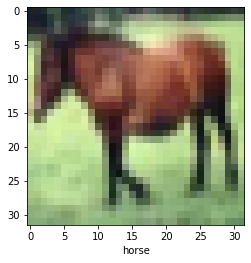

In [8]:
# 看一下資料長怎樣:
IMG_INDEX = 7
plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

## Create CNN

```python
.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
```
依序代表:
- filter 的大小是 3*3，且有 32 層。
- 是用 relu activation function。<font color='red'> Activation function 的使用時機是 input feature map 與 filter 做完 dot product(內積) 後，就丟進 activation function。</font>
- input data 的 shape 是 32*32，且有 3 層。

```python
.MaxPooling2D( (2, 2) )
```
代表 pooling 的大小是 2*2 (stride = 2)。

注意到第二層的 filter 頻率提升到了 64。
 
> We can do this as our data shrinks in spacial dimensions as it passed through the layers.  
> we can afford (computationally) to add more depth.

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 用 <font color='green'> .summary() </font> 來查看 model。

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


注意到:  
1. 
    經過一層 layer(conv2d)，output 從原本的 32*32*3 變成了 30*30*32:  
    這是因為我們沒有做 padding，因此 output feature 本來就會比較小。  
    至於為何從 3 變為 32? 可能是因為經過 filters(沒有很確定)。
2.  經過一層 max_pooling 後，output 大小從 30*30 變為 15*15。
    這是因為我們給的 pooling 是 2*2 的，因此會將原先的圖縮小 1 倍。

而這還不是最後，到目前為止，我們成功創建了 convolutional layers。  
但 convolutional layers 做的是將整張照片的所有 features 都找出來。  
下一步，應該將這些 features 做分類(比如如有這些 features 就分類為 class 1，有那些就分類為 class 2...)  
畢竟最終目標是輸出 0-10 的其中一個。

## Adding Dense Layers ( <font color='green'>.add() </font> )(to classify):

In [19]:
model.add(layers.Flatten()) # 將 4*4*64 拉成單維。
model.add(layers.Dense(64, activation='relu')) # fully dense
model.add(layers.Dense(10)) # output 必須是 10。

In [20]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

注意到 flatten 層的 1024，即為前一層的 4*4*64=1024。

## Compile the model ( <font color='green'>.compile()</font> ):

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Fit (the data to) the model (<font color='green'> .fit() </font>):

這次在 fit 時，多了 validation_data 的參數 (跟 Build a neuron network 比)，不太明白差別。  
根據 [這篇文章(第一個回答)](https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model)，如果多加了 validation_data，這樣就多一層驗證，accuracy 應該比較高。  
經過實驗好像是這樣。  
上面的圖是有加 validation_data。  
下面的圖則無。

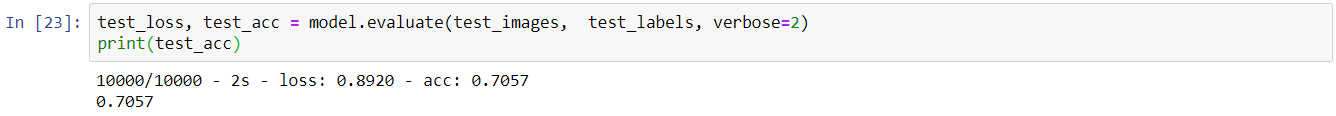
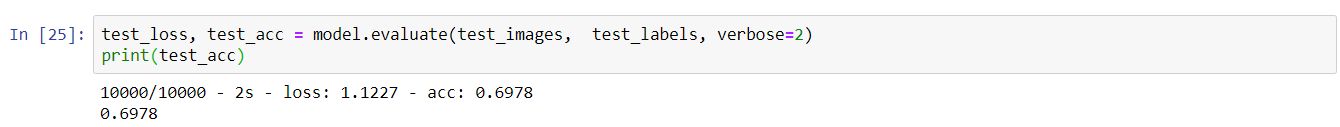

In [26]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 516us/sample - loss: 0.3598 - acc: 0.8713 - val_loss: 1.1967 - val_acc: 0.6915
Epoch 2/10
50000/50000 [==============================] - 24s 484us/sample - loss: 0.3483 - acc: 0.8752 - val_loss: 1.1682 - val_acc: 0.6998
Epoch 3/10
50000/50000 [==============================] - 24s 474us/sample - loss: 0.3250 - acc: 0.8844 - val_loss: 1.2270 - val_acc: 0.6972
Epoch 4/10
50000/50000 [==============================] - 24s 477us/sample - loss: 0.3091 - acc: 0.8898 - val_loss: 1.2540 - val_acc: 0.6922
Epoch 5/10
50000/50000 [==============================] - 24s 481us/sample - loss: 0.2894 - acc: 0.8965 - val_loss: 1.3093 - val_acc: 0.6952
Epoch 6/10
50000/50000 [==============================] - 23s 465us/sample - loss: 0.2845 - acc: 0.8980 - val_loss: 1.3249 - val_acc: 0.6974
Epoch 7/10
50000/50000 [==============================] - 23s 467us/sample - loss: 0.2767 - acc: 0.9003 

In [27]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

10000/10000 - 2s - loss: 1.4870 - acc: 0.6972
0.6972


由上面的例子我們發現，給了 60000 筆資料，但卻只有六十幾趴的精準度。    
這代表需要非常非常多的資料才能提升精準度。
------
那如果我就沒有那麼多資料呢?  
ANS: 我可以<font color='red'>將同一個資料(eg 圖片)，經過壓縮，拉長，旋轉，壓扁...等方法，讓一張照片變為很多張不同的照片。</font>    

### Data Augmentation(增廣)

Using TensorFlow backend.


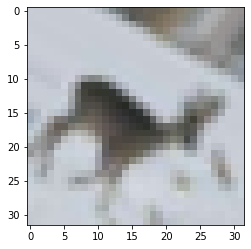

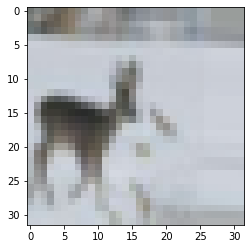

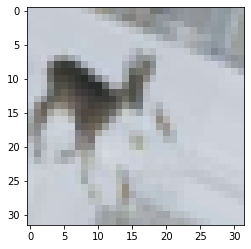

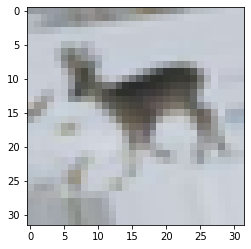

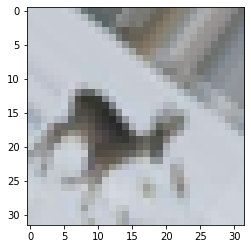

In [29]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# creates a data generator object that transforms images
# 將 input data(圖片)做一些處理。
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
#-------------------------------------------------------------------------------------------------------------------------

# 隨便挑一張來測試:
test_img = train_images[20]
img = image.img_to_array(test_img)  # convert image to numpy arry
img = img.reshape((1,) + img.shape)  # reshape image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4:  # show 4 images
        break

plt.show()